In [43]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt


import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 500e-3
fsm_pupil_diam = 10e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)



13.056562235441199 arcsec
0.1090047393364929


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 200
cam.set_roi(475, 850, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

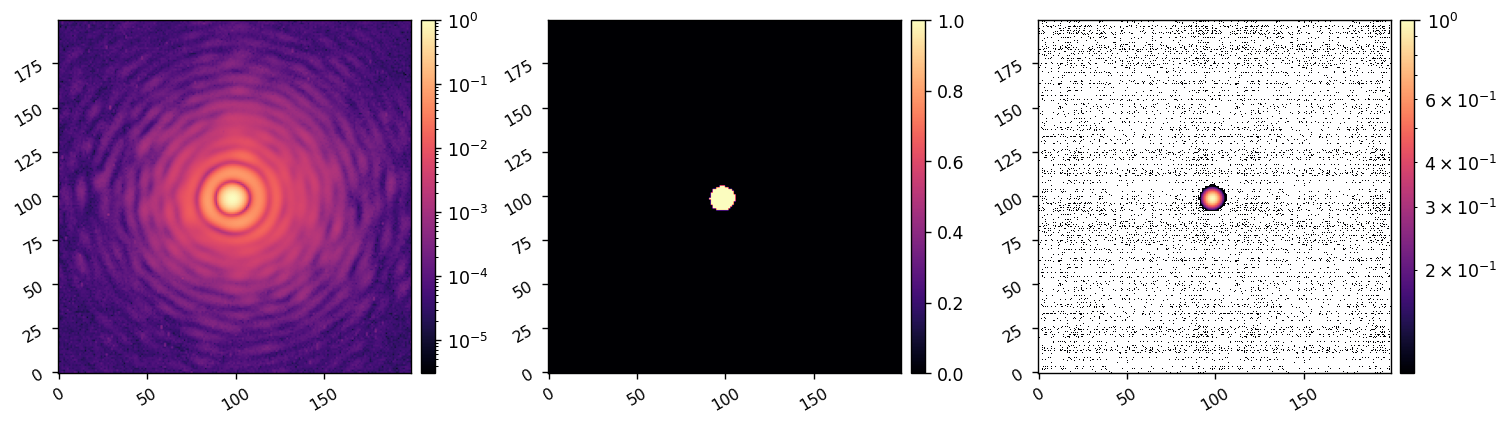

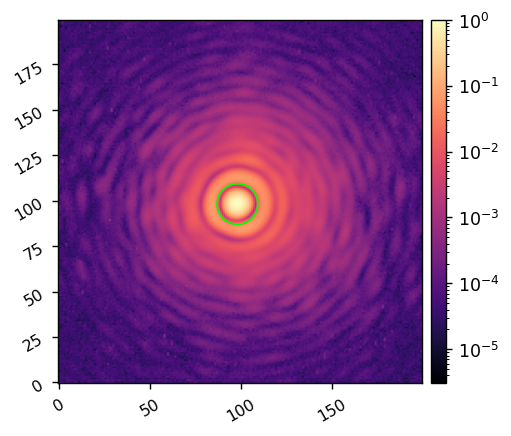

In [27]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.1, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [7]:
fps = client0[f'campupil.fps.current']
print(fps)

715.307556152344


In [30]:
texp = 10
cam.Nframes = texp*fps

In [74]:
frames = cam.snap_cube()

In [32]:
frames.size * 2 /1e9

0.57232

In [75]:
freq = 3
hdr = {
    'FPS':fps, 
}
utils.save_fits(f'data/fsm_mod_cube_1lamD_{freq:04d}.fits', frames, header=hdr)

Saved data to:  data/fsm_mod_cube_1lamD_0003.fits


In [142]:
freq = 3
fname = f'data/fsm_mod_cube_1lamD_{freq:04d}.fits'
fsm_cube, fsm_hdr = utils.load_fits(fname, header=True)
fps = fsm_hdr['FPS']
npsf = fsm_cube.shape[1]
Nframes = fsm_cube.shape[0]
times = np.linspace(0, Nframes /fps, Nframes)

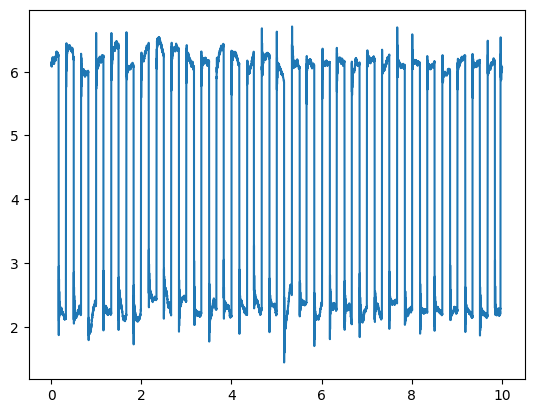

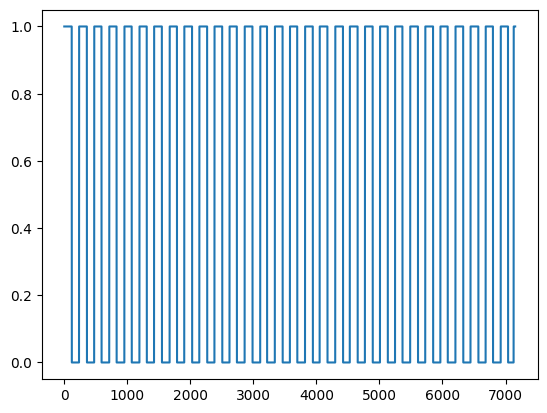

In [143]:
cents = []
dists = []
for i in range(fsm_cube.shape[0]):
    frame = fsm_cube[i].astype(np.float64)
    cen = utils.centroid(frame, thresh=0.1) - npsf/2
    cents.append(cen)
    dists.append(np.sqrt(cen[0]**2 + cen[1]**2))
cents = np.array(cents)
dists = np.array(dists)

plt.plot(times, dists)
plt.show()
pulse = np.int16(dists>4)
plt.plot(pulse)
plt.show()


In [146]:
con_ones = []
con_zeros = []
count = 0
for i in range(Nframes-1):
    if pulse[i+1]-pulse[i]!=0:
        if pulse[i]==1:
            con_ones.append(count)
        elif pulse[i]==0:
            con_zeros.append(count)
        count = 0
    count += 1
con_ones = np.array(con_ones)
con_zeros = np.array(con_zeros)[1:]
# print(con_zeros)

meas_freq = np.mean([fps/np.mean(con_ones)/2, fps/np.mean(con_zeros)/2])
print(meas_freq)

3.0102118181115234
